In [57]:
import os
import sqlite3
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

sns.set_style("whitegrid")

In [58]:
def generate_course_data(n_samples=1000, seed=42, version=1):
    np.random.seed(seed)

    courses = ['AI & ML', 'Data Science', 'Cybersecurity', 'Cloud Computing',
               'Business Analytics', 'Software Engineering', 'Digital Marketing',
               'Blockchain', 'IoT', 'DevOps']

    df = pd.DataFrame({
        'course_id': range(1, n_samples + 1),
        'course_name': np.random.choice(courses, n_samples),
        'semester': np.random.randint(1, 9, n_samples),
        'faculty_rating': np.round(np.random.uniform(3.0, 5.0, n_samples), 2),
        'previous_enrollment': np.random.randint(15, 150, n_samples),
        'course_difficulty': np.random.randint(1, 6, n_samples),
        'is_elective': np.random.choice([0,1], n_samples),
        'has_lab': np.random.choice([0,1], n_samples),
        'industry_demand': np.random.randint(1, 11, n_samples),
        'year': np.random.choice([2022, 2023, 2024], n_samples),
        'season': np.random.choice(['Fall','Spring','Summer'], n_samples)
    })

    df['expected_enrollment'] = (
        df['previous_enrollment'] * 0.5 +
        df['faculty_rating'] * 12 +
        df['industry_demand'] * 3 +
        df['is_elective'] * 8 -
        df['has_lab'] * 5 -
        df['course_difficulty'] * 8 +
        np.random.randint(-15, 15, n_samples)
    ).astype(int)

    df['expected_enrollment'] = df['expected_enrollment'].clip(10, 200)
    df['data_version'] = version
    df['generated_date'] = datetime.now()

    return df


df = generate_course_data()

In [59]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1000, 14)


,course_id,course_name,semester,faculty_rating,previous_enrollment,course_difficulty,is_elective,has_lab,industry_demand,year,season,expected_enrollment,data_version,generated_date
0,1,Digital Marketing,1,4.39,63,1,0,0,9,2024,Fall,113,1,2026-02-08 06:06:21.200981
1,2,Cloud Computing,7,4.64,60,1,1,1,1,2024,Summer,85,1,2026-02-08 06:06:21.200981
2,3,Blockchain,8,3.08,127,3,1,0,10,2023,Summer,126,1,2026-02-08 06:06:21.200981
3,4,Business Analytics,4,4.34,57,2,1,1,6,2023,Spring,98,1,2026-02-08 06:06:21.200981
4,5,Digital Marketing,3,4.90,138,3,1,1,6,2023,Fall,131,1,2026-02-08 06:06:21.200981


In [60]:
os.makedirs("data", exist_ok=True)
db_path = "data/course_data.db"

conn = sqlite3.connect(db_path)
df.to_sql("course_table", conn, if_exists="replace", index=False)
conn.close()

print("Data saved to SQLite")

Data saved to SQLite


In [61]:
conn = sqlite3.connect(db_path)
df = pd.read_sql("SELECT * FROM course_table", conn)
conn.close()

df.head()

,course_id,course_name,semester,faculty_rating,previous_enrollment,course_difficulty,is_elective,has_lab,industry_demand,year,season,expected_enrollment,data_version,generated_date
0,1,Digital Marketing,1,4.39,63,1,0,0,9,2024,Fall,113,1,2026-02-08 06:06:21.200981
1,2,Cloud Computing,7,4.64,60,1,1,1,1,2024,Summer,85,1,2026-02-08 06:06:21.200981
2,3,Blockchain,8,3.08,127,3,1,0,10,2023,Summer,126,1,2026-02-08 06:06:21.200981
3,4,Business Analytics,4,4.34,57,2,1,1,6,2023,Spring,98,1,2026-02-08 06:06:21.200981
4,5,Digital Marketing,3,4.90,138,3,1,1,6,2023,Fall,131,1,2026-02-08 06:06:21.200981


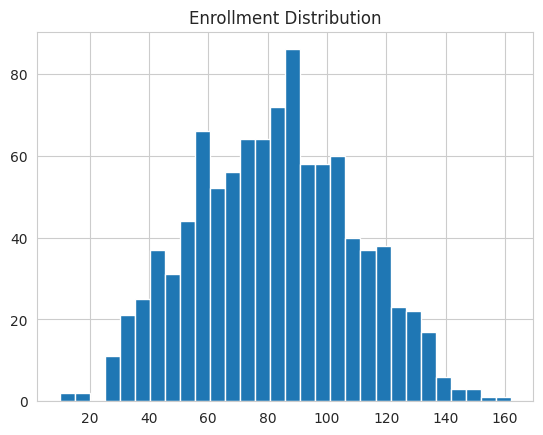

In [62]:
plt.figure()
plt.hist(df['expected_enrollment'], bins=30)
plt.title("Enrollment Distribution")
plt.show()

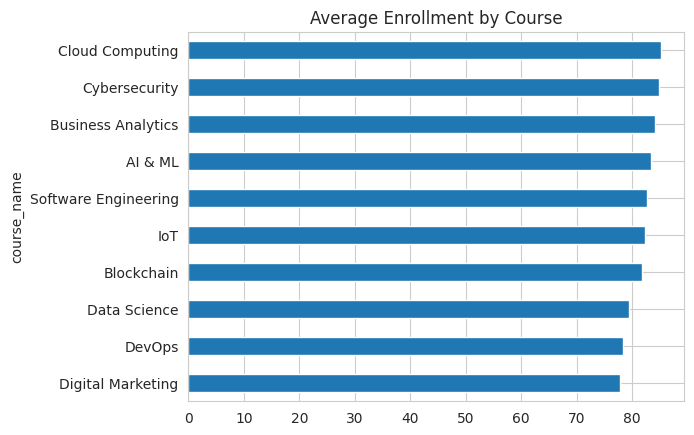

In [63]:
plt.figure()
df.groupby('course_name')['expected_enrollment'].mean().sort_values().plot(kind='barh')
plt.title("Average Enrollment by Course")
plt.show()

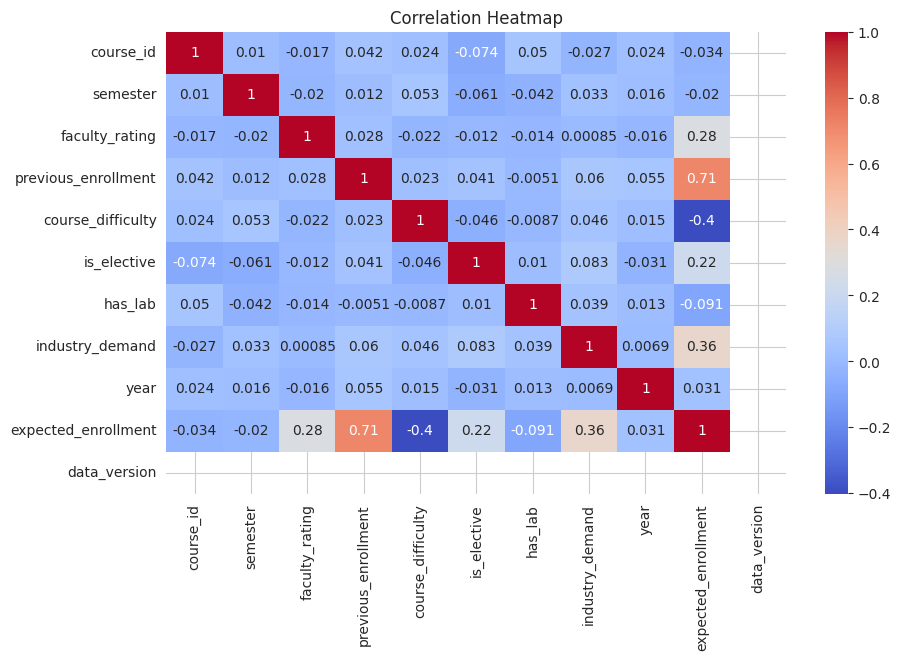

In [64]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [65]:
le_course = LabelEncoder()
le_season = LabelEncoder()

df['course_encoded'] = le_course.fit_transform(df['course_name'])
df['season_encoded'] = le_season.fit_transform(df['season'])

features = [
    'course_encoded','semester','faculty_rating','previous_enrollment',
    'course_difficulty','is_elective','has_lab','industry_demand',
    'year','season_encoded'
]

X = df[features]
y = df['expected_enrollment']

os.makedirs("models", exist_ok=True)
joblib.dump(le_course, "models/course_encoder.pkl")
joblib.dump(le_season, "models/season_encoder.pkl")

['models/season_encoder.pkl']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)

    results[name] = {
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": rmse
    }

    trained_models[name] = model

results_df = pd.DataFrame(results).T
results_df

,R2,MAE,RMSE
Linear Regression,0.892405,7.915526,9.075735
Decision Tree,0.691536,12.254613,15.366943
Random Forest,0.814926,9.776071,11.903027


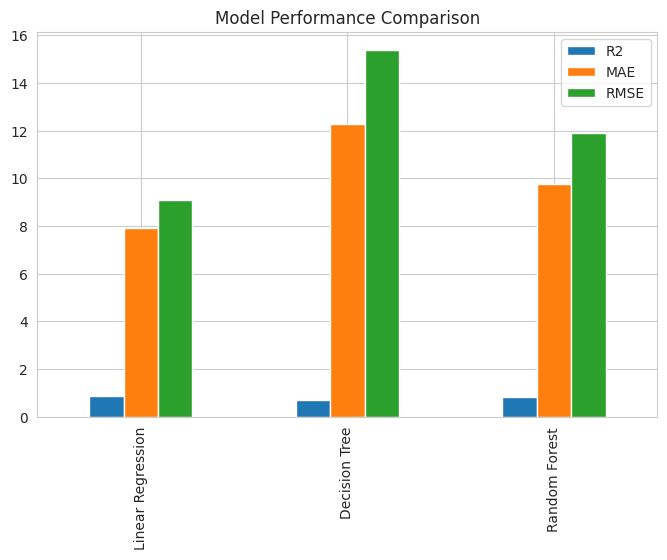

In [67]:
results_df.plot(kind='bar', figsize=(8,5))
plt.title("Model Performance Comparison")
plt.show()

In [68]:
best_model_name = results_df['R2'].idxmax()
best_model = trained_models[best_model_name]

joblib.dump(best_model, "models/best_model.pkl")

print("Best Model:", best_model_name)

Best Model: Linear Regression


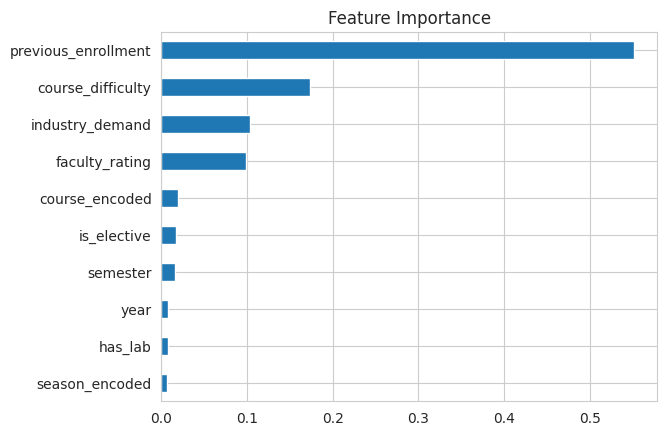

In [69]:
rf = trained_models["Random Forest"]

importance = pd.Series(rf.feature_importances_, index=features)
importance.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [70]:
# ----------------------------
# Prediction Function
# ----------------------------
def predict_enrollment(input_dict):
    course_encoded = le_course.transform([input_dict['course_name']])[0]
    season_encoded = le_season.transform([input_dict['season']])[0]

    input_df = pd.DataFrame({
        "course_encoded": [course_encoded],
        "semester": [input_dict['semester']],
        "faculty_rating": [input_dict['faculty_rating']],
        "previous_enrollment": [input_dict['previous_enrollment']],
        "course_difficulty": [input_dict['course_difficulty']],
        "is_elective": [input_dict['is_elective']],
        "has_lab": [input_dict['has_lab']],
        "industry_demand": [input_dict['industry_demand']],
        "year": [input_dict['year']],
        "season_encoded": [season_encoded]
    })

    prediction = best_model.predict(input_df)[0]
    return int(prediction)

In [71]:
# ----------------------------
# Batch Prediction Example
# ----------------------------
print("\nRunning batch predictions...")

batch_courses = [
    {
        'course_name': 'Data Science',
        'semester': 3,
        'faculty_rating': 4.2,
        'previous_enrollment': 75,
        'course_difficulty': 4,
        'is_elective': 1,
        'has_lab': 1,
        'industry_demand': 8,
        'year': 2024,
        'season': 'Spring'
    },
    {
        'course_name': 'Cybersecurity',
        'semester': 6,
        'faculty_rating': 4.7,
        'previous_enrollment': 60,
        'course_difficulty': 3,
        'is_elective': 0,
        'has_lab': 1,
        'industry_demand': 9,
        'year': 2024,
        'season': 'Fall'
    },
    {
        'course_name': 'Cloud Computing',
        'semester': 7,
        'faculty_rating': 3.8,
        'previous_enrollment': 45,
        'course_difficulty': 2,
        'is_elective': 1,
        'has_lab': 0,
        'industry_demand': 10,
        'year': 2024,
        'season': 'Summer'
    }
]

batch_results = []

for course in batch_courses:
    prediction = predict_enrollment(course)

    batch_results.append({
        'Course': course['course_name'],
        'Semester': course['semester'],
        'Previous Enrollment': course['previous_enrollment'],
        'Faculty Rating': course['faculty_rating'],
        'Predicted Enrollment': prediction
    })

batch_df = pd.DataFrame(batch_results)

print("\nBatch Prediction Results:")
print("=" * 80)
print(batch_df.to_string(index=False))
print("=" * 80)


Running batch predictions...

Batch Prediction Results:
         Course  Semester  Previous Enrollment  Faculty Rating  Predicted Enrollment
   Data Science         3                   75             4.2                    82
  Cybersecurity         6                   60             4.7                    83
Cloud Computing         7                   45             3.8                    90


In [72]:
# ----------------------------
# Project Summary
# ----------------------------

best_r2 = results_df.loc[best_model_name, "R2"]

print("\n" + "="*80)
print("                 PROJECT COMPLETION SUMMARY")
print("="*80)

print(f"\nTotal Records Generated: {len(df)}")
print(f"Models Trained: {len(trained_models)}")
print(f"Best Model: {best_model_name}")
print(f"Best R2 Score: {best_r2:.4f}")
print("Database: data/course_data.db")
print("Saved Models: models/best_model.pkl")
print("Encoders: course_encoder.pkl, season_encoder.pkl")

print("\nProject completed successfully!")
print("="*80)


                 PROJECT COMPLETION SUMMARY

Total Records Generated: 1000
Models Trained: 3
Best Model: Linear Regression
Best R2 Score: 0.8924
Database: data/course_data.db
Saved Models: models/best_model.pkl
Encoders: course_encoder.pkl, season_encoder.pkl

Project completed successfully!
